In [234]:
#import yfinance as yf
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from pykalman import KalmanFilter
from enum import Enum
warnings.filterwarnings('ignore')
class Model(Enum):
    KALMAN = 'Kalman'

# Blended Strategy Implementation

In [235]:
def slope_intercept_Kalman(data, asset1, asset2):
    """
    Applies a Kalman Filter to estimate the time-varying hedge ratio (slope) and intercept
    in the log-price relationship between two assets.

    Parameters:
    - data (pd.DataFrame): DataFrame containing price columns for asset1 and asset2.
    - asset1 (str): Column name for the first asset (independent variable).
    - asset2 (str): Column name for the second asset (dependent variable).

    Returns:
    - data (pd.DataFrame): Original DataFrame with added 'slope' and 'intercept' columns.
    - all_resid (pd.Series): Series of residuals from the dynamic linear regression:
        log(asset2) - slope * log(asset1) - intercept
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    obs_mat = np.vstack(
        [np.log(data[asset1]), np.ones(np.log(data[asset1]).shape)]
    ).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    filter_mean, _ = kf.filter(np.log(data[asset2]).values)
    data['slope'] = filter_mean[:, 0]
    data['intercept'] = filter_mean[:, 1]

    all_resid = np.log(data[asset2]) - np.log(data[asset1]) * data['slope'] - data['intercept']
    return data, all_resid

def compute_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    """
    Computes the Relative Strength Index (RSI), a momentum oscillator that measures
    the speed and magnitude of recent price changes to identify overbought or oversold conditions.

    Parameters:
    - prices (pd.Series): Time series of asset prices.
    - window (int): Lookback period (default is 14).

    Returns:
    - rsi (pd.Series): RSI values ranging from 0 to 100.
      - RSI > 50 typically indicates overbought conditions.
      - RSI < 30 typically indicates oversold conditions.
    """
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [236]:
def blend_strategy(
    asset1: str,
    asset2: str,
    data: pd.DataFrame,
    fixed_mean: float, 
    rolling_window: int = 20,
    neutral_threshold: float = 0.5,
    entry_threshold: float = 2,
    exit_threshold: float = -0.1,
    relaxed_exit: float = 1.0,

    hedge_ratio: float = 0.27,
    ma_short_window: int = 5,
    ma_long_window: int = 20,
    min_start_index: int = 20,
    tolerance: float = 1,
    model_name: Model = Model.KALMAN
    ):
    """
    Blended mean-reversion and trend-following pairs trading strategy.

    Strategy Logic:
    - Uses residuals from Kalman spread estimation.
    - Mean-reversion:
        - Enter long if z-score < -entry_threshold
        - Enter short if z-score > +entry_threshold
        - Exit if z-score crosses back within +/- exit_threshold
        - If holding over 180 days:
            - If spread is trending against the position, force exit and pause trades
            - If trend is flat, allow exit at a relaxed threshold
        - Resume trading only if z-score returns near 0 after forced exit
    - Trend-following:
        - If z-score is near 0 (within neutral_threshold) and RSI of asset1 is larger than 50, enter long trend position (buy both assets)
        - Exit trend-following if z-score moves out of neutral range or if RSI decreases to less than 30

    Parameters:
    - asset1 / asset2: Names of the paired assets (tickers)
    - data: DataFrame with asset1 and asset2 columns
    - all_resid: Spread residuals from the chosen model (OLS or Kalman)
    - fixed_mean: Long-term average of residual calculated using kalman filter parameters (2012-2021 data is used)
    - rolling_window: Window size for rolling standard deviation of residual
    - neutral_threshold: Z-score range around 0 to trigger trend-following
    - entry_threshold: Z-score to enter a mean-reversion trade
    - exit_threshold: Z-score to exit a mean-reversion trade
    - relaxed_exit: Relaxed z-score for exiting after long holding with flat spread trend
    - hedge ratio: fixed hedge ratio obtained from historical period
    - ma_short_window / ma_long_window: Rolling windows for trend detection using short/long spread or price averages
    - min_start_index: First index to consider signals, after warm-up period
    - tolerance: Absolute z-score to resume trading after a forced pause
    - model_name: Model enum (Model.OLS or Model.KALMAN) for residual generation

    Returns:
    - trades: DataFrame of executed trades with entry/exit prices, direction, and PnL
    """
    # Calculate z-score and moving averages
    if model_name == Model.KALMAN:
        data, all_resid = slope_intercept_Kalman(data, asset1, asset2)
    else:
        raise ValueError("Invalid model name!")

    resid_std = all_resid.rolling(rolling_window).std()
    z_score = (all_resid - fixed_mean) / resid_std
    spread_short_mean = all_resid.rolling(window=ma_short_window).mean()
    spread_long_mean = all_resid.rolling(window=ma_long_window).mean()

    rsi1 = compute_rsi(data[asset1])
    rsi2 = compute_rsi(data[asset2])


    # Plotting thresholds
    up_threshold = fixed_mean + entry_threshold * resid_std
    down_threshold = fixed_mean - entry_threshold * resid_std

    position = 0              # 0 = no position, 1 = long all_resid, -1 = short all_resid, 2 = long both asset
    trade_log = []            # Store trade history
    signals = []              # Store visual signals
    mean_revertion_paused = False  # If True, skip trade signals until residuals approach mean    
    trend_following = False        # If True, pause mean revertion strategy until residuals move against from mean
    for i in range(min_start_index, len(all_resid)):
        date = all_resid.index[i]
        if z_score[i] == 0 or np.isnan(z_score[i]):
            continue

        # Resume trading only if all_resid has reverted back near long-term mean
        if mean_revertion_paused and abs(z_score[i]) < tolerance:
            mean_revertion_paused = False

        # Entry logic (only if not mean_revertion_paused)
        if position == 0:
            if (
                -neutral_threshold <= z_score[i] <= neutral_threshold and
                rsi1.iloc[i] > 50 and rsi2.iloc[i] > 50 # confirm upward momentum
            ):
                # enter long trend-following

                trend_following = True
                position = 2  # Use 2 to denote spread_trend-following long, we assume a long term up spread_trend for both assets in this strategy

                entry_date = date
                entry_price1 = data.loc[entry_date, asset1]
                entry_price2 = data.loc[entry_date, asset2]
                direction = f"Trend Long {asset1} / Short {asset2}"
                signals.append((date, all_resid[i], 'buy_trend'))

            if not mean_revertion_paused and not mean_revertion_paused:
                if z_score[i] > entry_threshold:
                    # Short the spread (KO expensive, PEP cheap)
                    position = -1
                    entry_date = date
                    entry_price1 = data.loc[entry_date, asset1]
                    entry_price2 = data.loc[entry_date, asset2]
                    direction = f"Short {asset1} / Long {asset2}"
                    signals.append((date, all_resid[i], 'sell'))
                elif z_score[i] < -entry_threshold and not trend_following:
                    # Long the spread (KO cheap, PEP expensive)
                    position = 1
                    entry_date = date
                    entry_price1 = data.loc[entry_date, asset1]
                    entry_price2 = data.loc[entry_date, asset2]
                    direction = f"Long {asset1} / Short {asset2}"
                    signals.append((date, all_resid[i], 'buy'))

        elif position == 1:
            holding_days = (date - entry_date).days
            spread_trend = spread_short_mean[i] - spread_long_mean[i]

            # Normal exit if z-score reverts
            if z_score[i] >= -exit_threshold or i == len(all_resid) - 1:
                exit_price1 = data.loc[date, asset1]
                exit_price2 = data.loc[date, asset2]
                pnl = (exit_price1 - entry_price1) + (entry_price2 - exit_price2) * hedge_ratio
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": date,
                    "Direction": direction,
                    "Entry Price 1": entry_price1,
                    "Entry Price 2": entry_price2,
                    "Exit Price 1": exit_price1,
                    "Exit Price 2": exit_price2,
                    "PnL": pnl
                })
                position = 0

            # Stop-loss or relaxed exit after 180 days of holding
            elif holding_days > 180:
                if spread_trend > 0:  # Trend is continuing in wrong direction → force stop
                    exit_price1 = data.loc[date, asset1]
                    exit_price2 = data.loc[date, asset2]
                    data['hedge ratios'] = data['slope'][i]
                    pnl = (exit_price1 - entry_price1) + (entry_price2 - exit_price2) * data['hedge ratios'][i] * (exit_price1 / exit_price2)
                    trade_log.append({
                        "Entry Date": entry_date,
                        "Exit Date": date,
                        "Direction": direction,
                        "Entry Price 1": entry_price1,
                        "Entry Price 2": entry_price2,
                        "Exit Price 1": exit_price1,
                        "Exit Price 2": exit_price2,
                        "PnL": pnl
                    })
                    position = 0
                    mean_revertion_paused = True
                elif abs(spread_trend) < 0.01:  # Flat spread_trend, allow relaxed exit
                    if z_score[i] >= -relaxed_exit:
                        exit_price1 = data.loc[date, asset1]
                        exit_price2 = data.loc[date, asset2]
                        data['hedge ratios'] = data['slope'][i]
                        pnl = (exit_price1 - entry_price1) + (entry_price2 - exit_price2) * data['hedge ratios'][i] * (exit_price1 / exit_price2)
                        trade_log.append({
                            "Entry Date": entry_date,
                            "Exit Date": date,
                            "Direction": direction,
                            "Entry Price 1": entry_price1,
                            "Entry Price 2": entry_price2,
                            "Exit Price 1": exit_price1,
                            "Exit Price 2": exit_price2,
                            "PnL": pnl
                        })
                        position = 0

        elif position == -1:
            holding_days = (date - entry_date).days
            spread_trend = spread_short_mean[i] - spread_long_mean[i]

            if z_score[i] <= exit_threshold or i == len(all_resid) - 1:
                exit_price1 = data.loc[date, asset1]
                exit_price2 = data.loc[date, asset2]
                data['hedge ratios'] = data['slope'][i]
                pnl = (entry_price1 - exit_price1) + (exit_price2 - entry_price2) * data['hedge ratios'][i] * (exit_price1 / exit_price2)
                
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": date,
                    "Direction": direction,
                    "Entry Price 1": entry_price1,
                    "Entry Price 2": entry_price2,
                    "Exit Price 1": exit_price1,
                    "Exit Price 2": exit_price2,
                    "PnL": pnl
                })
                position = 0

            elif holding_days > 180:
                if spread_trend < 0:  # Wrong spread_trend → stop-loss
                    exit_price1 = data.loc[date, asset1]
                    exit_price2 = data.loc[date, asset2]
                    data['hedge ratios'] = data['slope'][i]
                    pnl = (entry_price1 - exit_price1) + (exit_price2 - entry_price2) * data['hedge ratios'][i] * (exit_price1 / exit_price2)
                    trade_log.append({
                        "Entry Date": entry_date,
                        "Exit Date": date,
                        "Direction": direction,
                        "Entry Price 1": entry_price1,
                        "Entry Price 2": entry_price2,
                        "Exit Price 1": exit_price1,
                        "Exit Price 2": exit_price2,
                        "PnL": pnl
                    })
                    position = 0
                    mean_revertion_paused = True
                elif abs(spread_trend) < 0.01:  # Flat spread_trend → allow relaxed exit
                    if z_score[i] <= relaxed_exit:
                        exit_price1 = data.loc[date, asset1]
                        exit_price2 = data.loc[date, asset2]
                        data['hedge ratios'] = data['slope'][i]
                        pnl = (entry_price1 - exit_price1) + (exit_price2 - entry_price2) * data['hedge ratios'][i] * (exit_price1 / exit_price2)
                        trade_log.append({
                            "Entry Date": entry_date,
                            "Exit Date": date,
                            "Direction": direction,
                            "Entry Price 1": entry_price1,
                            "Entry Price 2": entry_price2,
                            "Exit Price 1": exit_price1,
                            "Exit Price 2": exit_price2,
                            "PnL": pnl
                        })
                        position = 0
        
        elif position == 2:  # Trend-following long
            holding_days = (date - entry_date).days
            # Exit if price_trend reverses or z-score moves strongly against
            if (
                z_score[i] < -neutral_threshold or
                z_score[i] > neutral_threshold or
                rsi1.iloc[i] < 30 or
                rsi2.iloc[i] < 30 or
                i == len(all_resid) - 1
            ):
                exit_price1 = data.loc[date, asset1]
                exit_price2 = data.loc[date, asset2]
                pnl = (exit_price1 - entry_price1) + hedge_ratio * (exit_price2 - entry_price2)
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": date,
                    "Direction": direction,
                    "Entry Price 1": entry_price1,
                    "Entry Price 2": entry_price2,
                    "Exit Price 1": exit_price1,
                    "Exit Price 2": exit_price2,
                    "PnL": pnl
                })
                position = 0
                trend_following = False

    # Compute performance metrics
    trades = pd.DataFrame(trade_log)

    # -------------------- Figure 1: Spread & Signals --------------------
    plt.figure(figsize=(14, 6))
    plt.plot(all_resid, label="Spread", color='blue')
    plt.plot(up_threshold, color="red", linestyle="--", label="Upper Threshold")
    plt.plot(down_threshold, color="green", linestyle="--", label="Lower Threshold")

    for date, val, sig in signals:
        if sig == 'buy':
            plt.scatter(date, val, color='green', marker='^', s=100,
                        label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif sig == 'sell':
            plt.scatter(date, val, color='red', marker='v', s=100,
                        label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title("Figure 1: Mean Reversion Strategy - Spread with Entry/Exit Signals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # -------------------- Figure 2: Asset Prices with Trend Signals --------------------
    fig, ax_left = plt.subplots(figsize=(14, 6))
    ax_right = ax_left.twinx()

    line1, = ax_left.plot(data[asset1], label=f'{asset1} Price', color='purple')
    line2, = ax_right.plot(data[asset2], label=f'{asset2} Price', color='orange')

    for date, val, sig in signals:
        if sig == 'buy_trend' and date in data.index:
            ax_left.scatter(date, data.loc[date, asset1], color='green', marker='o', s=80,
                            label='Buy Trend Signal' if 'Buy Trend Signal' not in ax_left.get_legend_handles_labels()[1] else "")
            ax_right.scatter(date, data.loc[date, asset2], color='green', marker='o', s=80)

    ax_left.set_ylabel(f"{asset1} Price", color='purple')
    ax_right.set_ylabel(f"{asset2} Price", color='orange')
    ax_left.tick_params(axis='y', labelcolor='purple')
    ax_right.tick_params(axis='y', labelcolor='orange')

    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc='upper left')

    ax_left.set_title("Figure 2: Trend-Following Strategy - Asset Prices & Buy Signals")
    ax_left.grid(True)
    plt.tight_layout()
    plt.show()


    # -------------------- Figure 3: Z-score, Slope, and Intercept (3 subplots in one) --------------------
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

    # Subplot 1: Z-score with thresholds
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(z_score, label="Z-score", color='black')
    ax1.axhline(y=entry_threshold, color='red', linestyle='--', linewidth=1, label=f"+ Entry Threshold ({entry_threshold})")
    ax1.axhline(y=-entry_threshold, color='green', linestyle='--', linewidth=1, label=f"- Entry Threshold ({-entry_threshold})")
    ax1.axhline(y=neutral_threshold, color='grey', linestyle=':', linewidth=1, label=f"+ Neutral ({neutral_threshold})")
    ax1.axhline(y=-neutral_threshold, color='grey', linestyle=':', linewidth=1, label=f"- Neutral ({-neutral_threshold})")
    ax1.set_ylabel("Z-score")
    ax1.set_title("Z-score with Entry and Neutral Thresholds")
    ax1.legend()
    ax1.grid(True)

    # Subplot 2: Kalman Slope
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(data['slope'], label="Kalman Slope", color='blue')
    ax2.set_ylabel("Slope")
    ax2.set_title("Kalman Filter Estimated Hedge Ratio (Slope)")
    ax2.legend()
    ax2.grid(True)

    # Subplot 3: Kalman Intercept
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(data['intercept'], label="Kalman Intercept", color='red')
    ax3.set_ylabel("Intercept")
    ax3.set_title("Kalman Filter Estimated Intercept")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.suptitle("Figure 3: Z-score, Kalman Slope, and Intercept", y=1.02, fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

    return trades 

In [237]:
def run_backtest(
    asset1: str,
    asset2: str,
    trades: pd.DataFrame,
    data: pd.DataFrame,
    hedge_ratio: float,
    initial_capital: float = 100_000,
    default_trade_unit: float = 10_000
):
    """
    Simulate backtest with actual trade execution based on asset1 (e.g., KO) and asset2 (e.g., PEP) prices.

    Parameters:
    - trades: DataFrame of trade history
    
    - hedge_ratio: weight applied to asset 2 (e.g., 0.27)
    - initial_capital: starting capital in USD
    - default_trade_unit: max dollar exposure per leg

    Returns:
    - metrics: performance dictionary
    - wealth_series: pd.Series of portfolio value over time
    """

    wealth = initial_capital
    wealth_history = [wealth]
    wealth_dates = [data.index[0]]

    for _, trade in trades.iterrows():
        entry_date = pd.to_datetime(trade["Entry Date"])
        exit_date = pd.to_datetime(trade["Exit Date"])
        direction = trade["Direction"]

        # Get prices at entry and exit
        entry_price1 = data[asset1].loc[entry_date]
        entry_price2 = data[asset2].loc[entry_date]
        exit_price1 = data[asset1].loc[exit_date]
        exit_price2 = data[asset2].loc[exit_date]
        
        # Capital-based trade sizing
        if 'Trend' in direction:
            if 'Long' in direction:
                max_units = wealth // (entry_price1 + hedge_ratio * entry_price2)
                trade_unit = min(default_trade_unit, max_units)
            else:
                trade_unit = default_trade_unit
        else:
            max_units1 = wealth // entry_price1
            max_units2 = wealth // entry_price2
            trade_unit = min(default_trade_unit, max_units1, max_units2)

        # PnL based on trade direction
        if 'Trend' in direction:
            if direction.startswith('Trend Long'):
                pnl = (exit_price1 - entry_price1) + hedge_ratio * (exit_price2 - entry_price2)
            else:
                pnl = - (exit_price1 - entry_price1) - hedge_ratio * (exit_price2 - entry_price2)
        else:
            hedge_ratio_mr = data['hedge ratios'].loc[exit_date] * exit_price1 / exit_price2
            if direction.startswith('Long'):
                pnl = ((exit_price1 - entry_price1) + (entry_price2 - exit_price2) * hedge_ratio_mr) * trade_unit
            else:
                pnl = ((entry_price1 - exit_price1) + (exit_price2 - entry_price2) * hedge_ratio_mr) * trade_unit

        wealth += pnl
        wealth_history.append(wealth)
        wealth_dates.append(exit_date)

    wealth_series = pd.Series(wealth_history, index=pd.to_datetime(wealth_dates)).sort_index()

    # Metrics
    final_wealth = wealth_series.iloc[-1]
    days = (wealth_series.index[-1] - wealth_series.index[0]).days
    annual_return = (final_wealth / initial_capital) ** (252 / days) - 1 if days > 0 else np.nan
    daily_returns = wealth_series.pct_change().dropna()
    
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if len(daily_returns) > 1 else np.nan
    peak = wealth_series.cummax()
    max_drawdown = ((peak - wealth_series) / peak).max()

    # Historical 1-day VaR at 95% and 99% confidence levels
    var_95 = np.percentile(daily_returns, 0.05) * wealth_series.iloc[-1]
    var_99 = np.percentile(daily_returns, 0.01) * wealth_series.iloc[-1]

    win_ratio = (trades["PnL"] > 0).mean() if not trades.empty else np.nan
    total_gain = trades.loc[trades["PnL"] > 0, "PnL"].sum()
    total_loss = -trades.loc[trades["PnL"] < 0, "PnL"].sum()
    profitability = total_gain / total_loss if total_loss > 0 else np.nan

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(wealth_series, label='Cumulative Wealth', color='darkblue')
    plt.title(f"Cumulative Wealth | Final: ${final_wealth:,.2f}")
    plt.xlabel("Date")
    plt.ylabel("Wealth ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    metrics = {
        "Final Wealth": final_wealth,
        "Annual Return (%)": annual_return,
        "Sharpe Ratio (daily)": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown,
        "1-Day VaR (95%)": var_95,
        "1-Day VaR (99%)": var_99,
        "Win Ratio": win_ratio,
        "Profitability (Gain/Loss Ratio)": profitability,
        "Total Trades": len(trades)
    }

    print("\n📊 Performance Summary:")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.2%}" if "%" in k and "VaR" not in k else f"{k}: {v:,.4f}")
        else:
            print(f"{k}: {v}")

    return metrics, wealth_series


## Stock pair trading

In [238]:
data = pd.read_csv("KO_PEP_close_2012_2025.csv", 
    header=[0, 1], 
    skiprows=[2], 
    index_col=0, 
    parse_dates=True )
stock1 = 'KO'
stock2 = 'PEP'
prices_data = data[[('Close', stock1), ('Close', stock2)]]
prices_data.columns = [stock1, stock2]
prices_data

,KO,PEP
2012-01-03,23.253370,45.088364
2012-01-04,23.107504,45.319256
2012-01-05,22.998095,44.966137
2012-01-06,22.852228,44.402542
2012-01-09,22.852228,44.633423
...,...,...
2024-12-24,62.379669,151.470779
2024-12-26,62.111645,151.104019
2024-12-27,61.992527,151.550079
2024-12-30,61.575600,150.390335


In [239]:
# Parameters
start_date = "2022-01-01"
end_date = "2025-01-01"
hedge_ratio = 0.27
test_data = prices_data.loc['2012-01-01':start_date]
_, test_resid = slope_intercept_Kalman(test_data.copy(), stock1, stock2)
fixed_mean = test_resid.mean()

# Download historical data
backtest_data = prices_data.loc[start_date:end_date]
data1 = backtest_data[stock1] #yf.download("KO", start=start_date, end=end_date)["Adj Close"]
data2 = backtest_data[stock2]

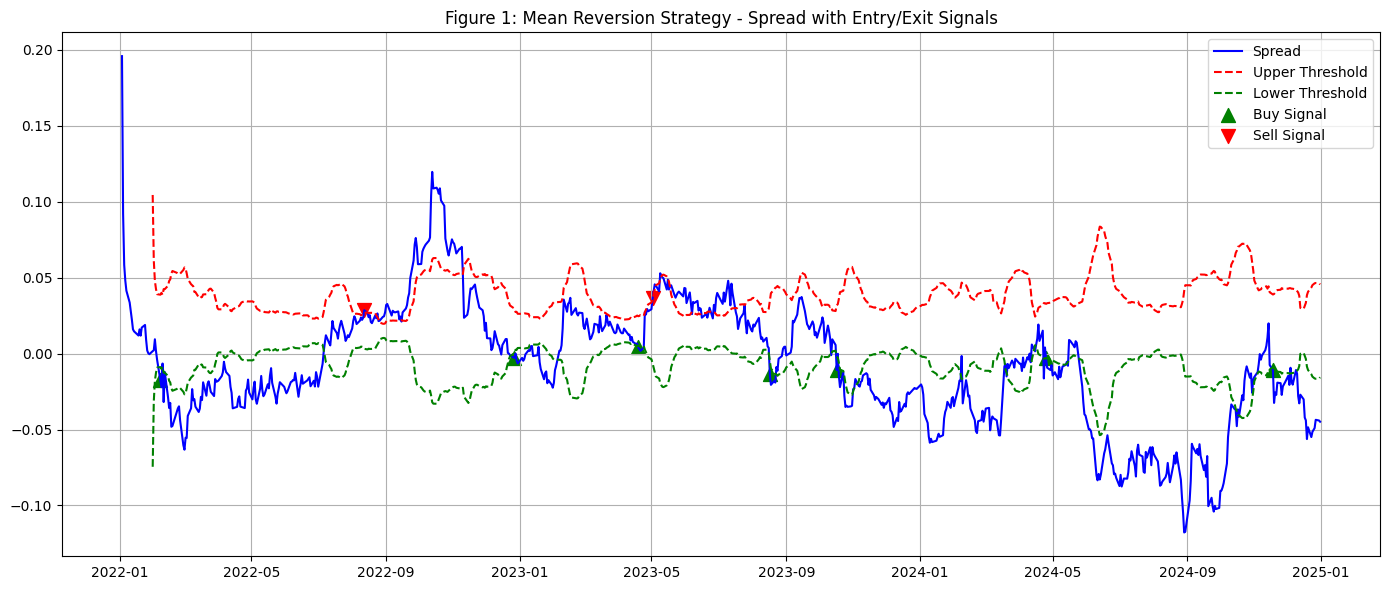

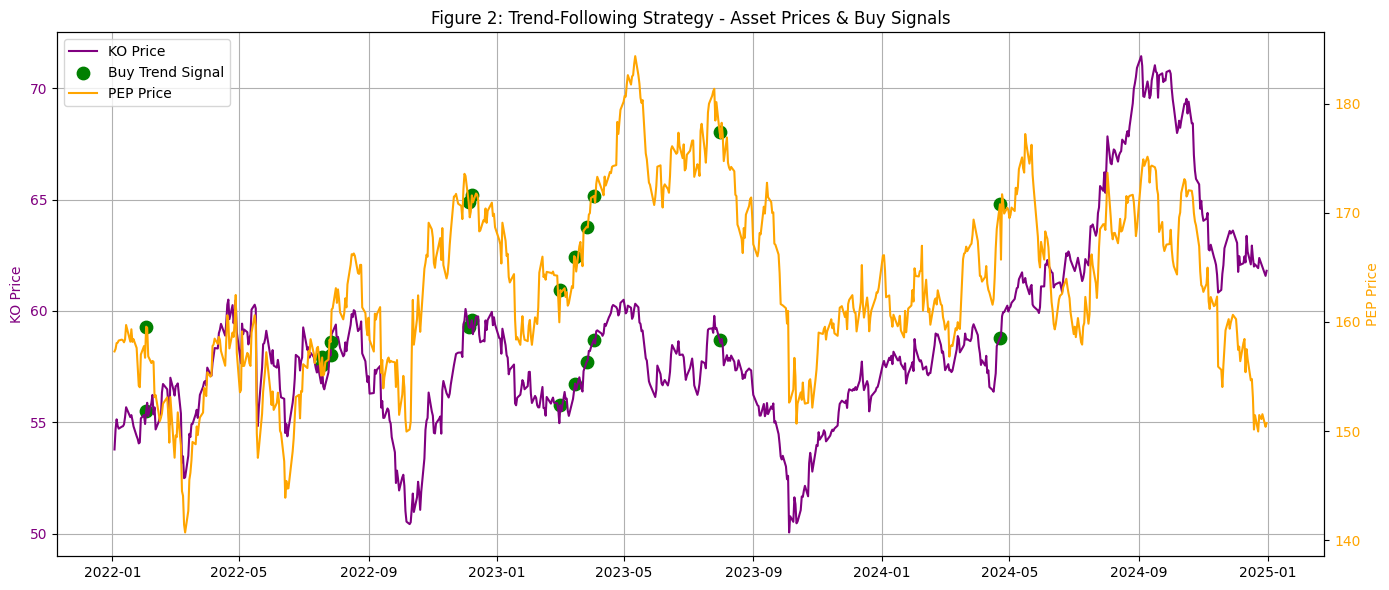

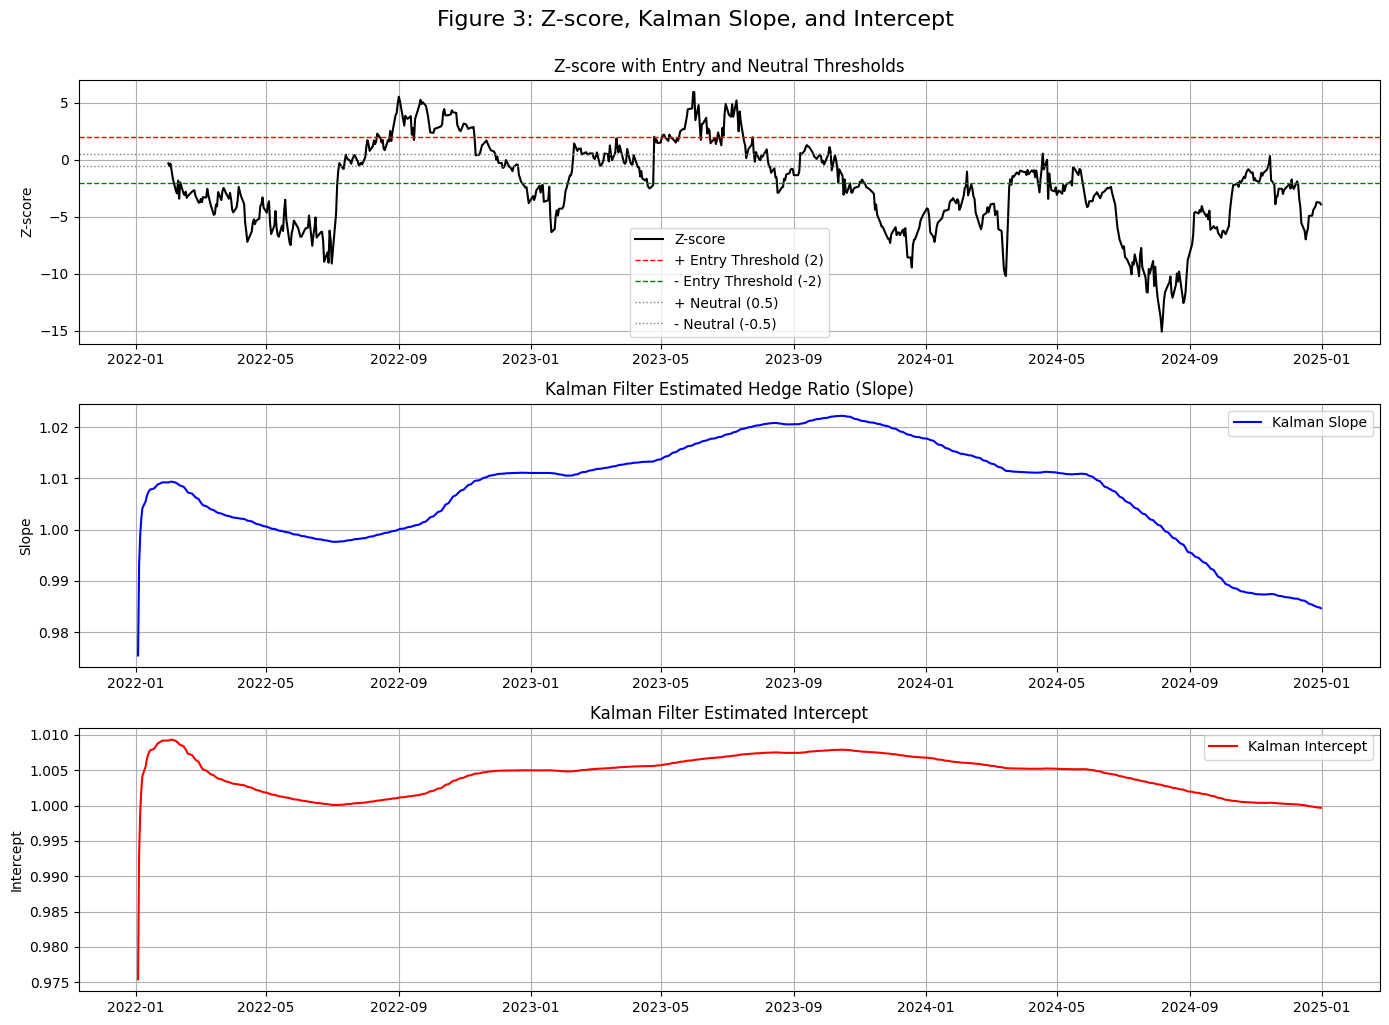

In [240]:
trades = blend_strategy(
    asset1=stock1,
    asset2=stock2,
    data = backtest_data,
    hedge_ratio=0.27, 
    fixed_mean=fixed_mean
)

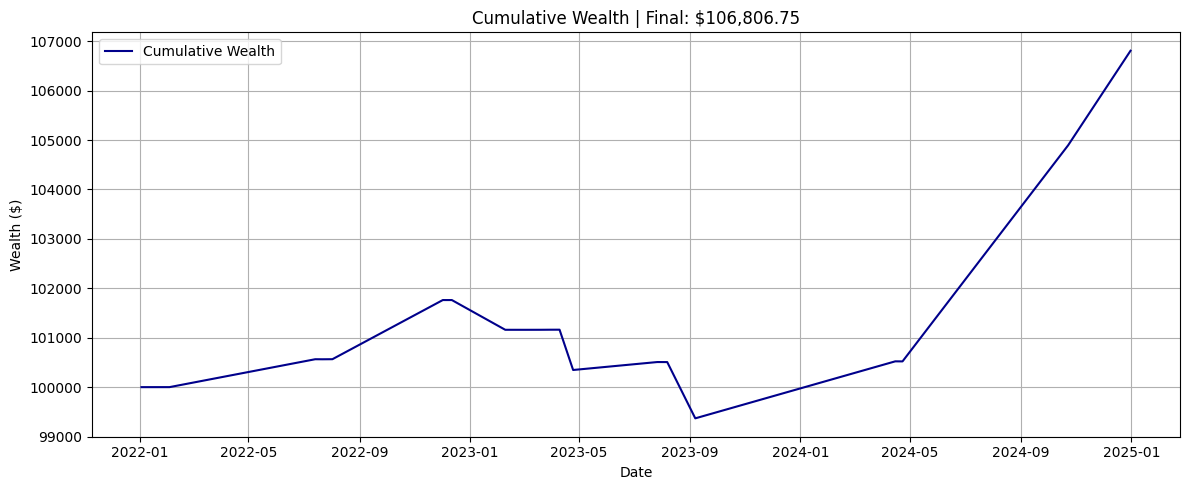


📊 Performance Summary:
Final Wealth: 106,806.7492
Annual Return (%): 1.53%
Sharpe Ratio (daily): 4.6155
Max Drawdown (%): 2.35%
1-Day VaR (95%): -1,206.2220
1-Day VaR (99%): -1,208.8719
Win Ratio: 0.6000
Profitability (Gain/Loss Ratio): 2.2288
Total Trades: 20


In [241]:
metrics, wealth_series = run_backtest(
    asset1=stock1, asset2=stock2,
    trades = trades,
    data=backtest_data,
    hedge_ratio=0.27,
    initial_capital=100000,
    default_trade_unit=1000
)

In [242]:
trades

,Entry Date,Exit Date,Direction,Entry Price 1,Entry Price 2,Exit Price 1,Exit Price 2,PnL
0,2022-02-02,2022-02-03,Trend Long KO / Short PEP,55.487930,159.562912,55.877918,159.471985,0.365438
1,2022-02-07,2022-07-14,Long KO / Short PEP,55.868843,156.234695,57.237148,157.591125,1.002069
2,2022-07-19,2022-07-22,Trend Long KO / Short PEP,57.559322,156.743149,56.694046,156.328369,-0.977267
3,2022-07-27,2022-08-02,Trend Long KO / Short PEP,58.001171,158.153320,58.581093,161.747940,1.550469
4,2022-08-12,2022-12-02,Short KO / Long PEP,58.636326,163.443848,60.089684,173.374161,2.025859
5,2022-12-05,2022-12-06,Trend Long KO / Short PEP,59.267944,170.974594,59.239933,169.583450,-0.403620
6,2022-12-08,2022-12-12,Trend Long KO / Short PEP,59.585434,171.590851,59.734844,171.768234,0.197304
7,2022-12-27,2023-02-09,Long KO / Short PEP,59.958946,170.927963,55.672832,161.320419,-1.692077
8,2023-03-02,2023-03-03,Trend Long KO / Short PEP,55.766220,162.918152,55.504753,162.758347,-0.304614
9,2023-03-16,2023-03-20,Trend Long KO / Short PEP,56.739727,165.916687,57.022007,166.931885,0.556383


# Run buy and hold

In [243]:
def run_buy_and_hold(
    data: pd.DataFrame, 
    asset1: str, 
    asset2: str,
    initial_capital: float = 100_000,
    hedge_ratio: float = 0.27,
    default_trade_unit: int = 1000
):
    """
    Simulate a passive buy-and-hold strategy with optional periodic rebalancing.

    Parameters:
    - data1 (pd.Series): Price series of asset 1 (e.g., KO).
    - data2 (pd.Series): Price series of asset 2 (e.g., PEP).
    - initial_capital (float): Starting portfolio value.
    - weight1 (float): Allocation weight to asset 1 (default 0.5).
    - weight2 (float): Allocation weight to asset 2 (default 0.5).
    - rebalanced (bool): If True, portfolio is rebalanced daily to maintain target weights.

    Returns:
    - metrics (dict): Dictionary of performance statistics.
    - wealth_series (pd.Series): Portfolio initial_capital over time.
    """
    entry_price1 = data[asset1].values[0]
    entry_price2 = data[asset2].values[0]
    max_units = initial_capital // (entry_price1 + hedge_ratio * entry_price2)
    trade_unit = min(default_trade_unit, max_units)
    wealth_series = initial_capital - trade_unit * (entry_price1 + hedge_ratio * entry_price2) + trade_unit * (data[asset1] + hedge_ratio * data[asset2])

    # Metrics
    final_wealth = wealth_series.iloc[-1]
    days = (wealth_series.index[-1] - wealth_series.index[0]).days
    annual_return = (final_wealth / initial_capital) ** (252 / days) - 1 if days > 0 else np.nan
    daily_returns = wealth_series.pct_change().dropna()
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if len(daily_returns) > 1 else np.nan
    peak = wealth_series.cummax()
    max_drawdown = ((peak - wealth_series) / peak).max()

    # VaR (historical 1-day)
    var_95 = np.percentile(daily_returns, 5) * wealth_series.iloc[-2]
    var_99 = np.percentile(daily_returns, 1) * wealth_series.iloc[-2]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(wealth_series, label="Buy & Hold Wealth", color="darkgreen")
    plt.title(f"Buy & Hold Strategy | Final Wealth: ${final_wealth:,.2f}")
    plt.xlabel("Date")
    plt.ylabel("Wealth ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    metrics = {
        "Final Wealth": final_wealth,
        "Annual Return (%)": annual_return,
        "Sharpe Ratio (daily)": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown,
        "1-Day VaR (95%)": var_95,
        "1-Day VaR (99%)": var_99,
    }

    return metrics, wealth_series


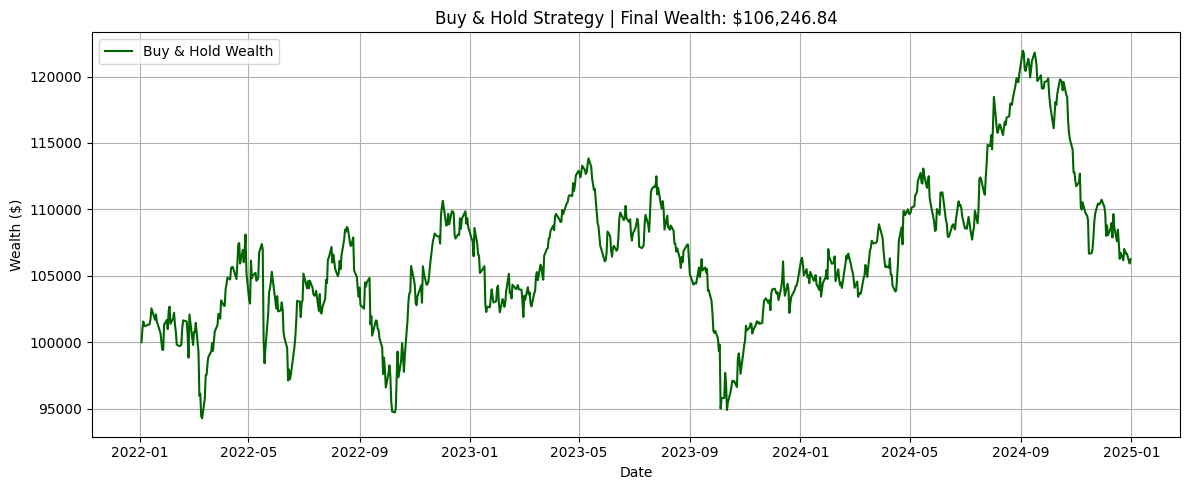

{'Final Wealth': 106246.83578491211,
 'Annual Return (%)': 0.01406867643818055,
 'Sharpe Ratio (daily)': 0.2121352365449167,
 'Max Drawdown (%)': 0.16642728238280885,
 '1-Day VaR (95%)': -1491.4217180896935,
 '1-Day VaR (99%)': -2449.146970071364}

In [244]:
bh_metrics, bh_wealth = run_buy_and_hold(
    data = backtest_data,
    asset1 = 'KO', 
    asset2 = 'PEP'
)
bh_metrics